## Introduction to Data Science

### Data Science Tasks: Geographical and Spatial Analysis

In [3]:
from __future__ import division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import twitter
import nltk
import re
import networkx as nx
import sys
import os
import json
import time
import urllib
import webbrowser
import codecs
import Levenshtein

from datetime import datetime
from datetime import timedelta
from itertools import chain
from itertools import cycle
from bs4 import BeautifulSoup
from nominatim import Nominatim
#from mpl_toolkits.basemap import Basemap   #http://matplotlib.org/basemap/api/basemap_api.html
from matplotlib import cm
import geopy.geocoders as gg

from IPython.display import Image, HTML, IFrame, FileLink, FileLinks #needed to render in notebook
from IPython.core.display import display

import pydotplus #Install http://www.graphviz.org/ & Instal https://pypi.python.org/pypi/pydotplus

%matplotlib inline
# Set default figure size for this notebook
plt.rcParams['figure.figsize'] = (16.0, 12.8)
#plt.switch_backend('Agg')

#### Specifying the path to the files

In [4]:
templates = "../templates/"
outputs = "../outputs/"

dotfile = "graph_retweet.dot"
pngfile = "graph_retweet.png"
protofile = "graph_retweet.html"
tweetsfile = "Tweets_dump.txt"
template_proto = 'template_protoviz.html'

pathdotfile = os.path.join(outputs,dotfile)
pathpngfile = os.path.join(outputs,pngfile)
pathprotofile = os.path.join(outputs,protofile)
pathtweetsfile = os.path.join(outputs,tweetsfile)
pathtemplate = os.path.join(templates,template_proto)

stoplist_en = nltk.corpus.stopwords.words('english')
stoplist_pt = nltk.corpus.stopwords.words('portuguese')
ignorewords = stoplist_en + stoplist_pt + ['',' ','-','rt']

### Using geographical resources within Python

In [5]:
#https://pypi.python.org/pypi/geopy  

gg.OpenMapQuest()
geolocator = gg.GoogleV3()

To geolocate a query to an address and coordinates:

In [6]:
logradouro = "Dona Mario ana, Botafoga" #Note that there are typos in the names
address, (latitude, longitude) = geolocator.geocode(logradouro)
print(address)
print(latitude, longitude)

Rua Dona Mariana - Botafogo, Rio de Janeiro - RJ, Brazil
-22.953195 -43.1885094


In [7]:
#Measuring editing distances between names:
Levenshtein.ratio('Dona Mariano, Botafoga', 'Rua Dona Mariana - Botafogo')

0.7755102040816326

In [8]:
#https://developers.google.com/maps/documentation/staticmaps/
#http://stackoverflow.com/questions/2660201/what-parameters-should-i-use-in-a-google-maps-url-to-go-to-a-lat-lon/9919251#9919251
#m – normal map k – satellite h – hybrid p – terrain

def gmap(address,lat,lon,zoom=15,tmap='m'):
    # Google Maps URL template for an iframe
    google_maps_url = 'http://maps.google.com/maps?q={0}&loc:{1}+{2}&z={3}&t={4}&output=embed'.format(address,
                                                                                                     lat,
                                                                                                     lon,
                                                                                                     zoom,
                                                                                                     tmap,)
    display(IFrame(google_maps_url, '800px', '600px'))
    
gmap(address, latitude, longitude,17,'k')

To find the address corresponding to a set of coordinates:

In [9]:
addresses = geolocator.reverse("-15.798,-47.865")
for address in addresses:
    print(address)

139 - Praça dos Três Poderes - Brasília, DF, Brazil
Praça dos Três Poderes - Brasília, DF, 70297-400, Brazil
Brasília - Brasilia, Federal District, Brazil
Brasilia, Federal District, Brazil
Asa Sul Entrequadra Sul 414/415 - Brasília, DF, 70297-400, Brazil
Brasilia - Federal District, Brazil
Brasilia - Federal District, Brazil
Brazil


### Using Python and QGIS for geospatial visualizations - a Case Study  
https://www.airpair.com/python/posts/using-python-and-qgis-for-geospatial-visualization  

In [10]:
base_url = "http://www.nuforc.org/webreports/"
index_url = "http://www.nuforc.org/webreports/ndxevent.html"

In [11]:
def can_cast_as_dt(dateStr, fmt):
    try:
        datetime.strptime(dateStr, fmt)
        return True
    except ValueError:
        return False

def parse_dt(dateStr):
    # the data in the website comes in two different formats, try both 
    for fmt in ["%m/%d/%y %H:%M", "%m/%d/%y"]:
        try:
            return datetime.strptime(dateStr, fmt)
        except ValueError:
            continue

def get_data_from_url(url):
    print("Processing {}".format(url))
    data = []
    source = BeautifulSoup(urllib.request.urlopen(url), "html5lib")
    for row in source('tr'):
        if not row('td'):
            continue # header row
        row_data = row('td')
        # parse the datetime from the string
        date_time = parse_dt(row_data[0].text)
        city = row_data[1].text
        state = row_data[2].text
        shape = row_data[3].text
        duration = row_data[4].text
        data.append((date_time, city, state, shape, duration))
    return data

In [12]:
# get the index page
raw_page = urllib.request.urlopen(index_url)
source = BeautifulSoup(raw_page, "html5lib")
# get all the links in the index page
func1 = lambda x: (x.text, base_url + x['href'])
monthly_urls = list(map(func1,source('a')))
# get  the last 12 links that have a text like 06/2015
func2 = lambda x: can_cast_as_dt(x[0], "%m/%Y")
last_year_urls = filter(func2, monthly_urls[0:13]) 
# extract the data from each monthly page and flatten the lists of tuples
last_year_ufos = list(chain(*map(lambda x: get_data_from_url(x[1]), last_year_urls)))
# initialize a pandas DataFrame with the list of tuples

Processing http://www.nuforc.org/webreports/ndxe201805.html
Processing http://www.nuforc.org/webreports/ndxe201804.html
Processing http://www.nuforc.org/webreports/ndxe201803.html
Processing http://www.nuforc.org/webreports/ndxe201802.html
Processing http://www.nuforc.org/webreports/ndxe201801.html
Processing http://www.nuforc.org/webreports/ndxe201712.html
Processing http://www.nuforc.org/webreports/ndxe201711.html
Processing http://www.nuforc.org/webreports/ndxe201710.html
Processing http://www.nuforc.org/webreports/ndxe201709.html
Processing http://www.nuforc.org/webreports/ndxe201708.html
Processing http://www.nuforc.org/webreports/ndxe201707.html
Processing http://www.nuforc.org/webreports/ndxe201706.html


In [13]:
ufos_df = pd.DataFrame(last_year_ufos, columns=["start","city","state","shape","duration_description"])

In [14]:
ufos_df.head()

,start,city,state,shape,duration_description
0,2018-05-14 21:00:00,Colorado Springs,CO,Light,20 minutes
1,2018-05-14 20:00:00,Murfreesboro,TN,Light,8 hours
2,2018-05-14 01:55:00,Manhattan Beach,CA,Formation,1-2 seconds
3,2018-05-14 00:00:00,"Washington, D.C.",DC,Disk,5 minutes
4,2018-05-13 21:20:00,Sparks,NV,Light,10 minutes


In [15]:
ufos_df.replace(to_replace='', value=np.nan, inplace=True, limit=None, regex=False, method='pad', axis=None)
ufos_df = ufos_df.dropna() 

TypeError: replace() got an unexpected keyword argument 'axis'

In [ ]:
ufos_df.head()

#### Engineering time

In [ ]:
# function that infers the duration from the text 
def infer_duration_in_seconds(text):
    # try different regexps to extract the total seconds
    text = text.replace('<','')
    text = text.replace('>','')
    text = text.replace('?','')
    text = text.replace('+','')
    text = text.replace('~','')
    metric_text = ["second","s","Second","segundo","minute","m","min","Minute","hour","h","Hour",'Currently']
    metric_seconds = [1,1,1,1,60,60,60,3600,3600,3600,10]
    for metric,mult in zip(metric_text, metric_seconds):
        regex = "\s*(\d+)\+?\s*{}s?".format(metric)
        res = re.findall(regex,text)
        if len(res)>0:
            return int(float(res[0]) * mult)
    return 0

In [ ]:
# extract the duration in seconds
ufos_df["duration_secs"] = ufos_df["duration_description"].apply(infer_duration_in_seconds)

# now we can infer the end time of the UFO sighting as well
# which will be useful for the animation later
ufos_df["end"] = ufos_df.apply(lambda x:x["start"] + timedelta(seconds=x["duration_secs"]),axis=1)
ufos_df = ufos_df.dropna()

In [ ]:
ufos_df.head()

#### Finding Locations

In [ ]:
# http://wiki.openstreetmap.org/wiki/Nominatim_usage_policy
# https://github.com/twain47/Nominatim/blob/master/docs/Installation.md
geolocator = Nominatim()

geolocator.query('Newport News')
#geolocator.query("Houston, TX")

In [ ]:
#Be careful with too many queries made to the server in a short period of time

ufos_df["lat"] = 0
ufos_df["lon"] = 0
for i in range(len(ufos_df[0:10])):
    try:
        resp_json = geolocator.query(ufos_df['city'][i])
        ufos_df["lat"][i] = resp_json[0]['lat']
        ufos_df["lon"][i] = resp_json[0]['lon']
    except:
        ufos_df["lat"][i] = 0
        ufos_df["lat"][i] = 0
    time.sleep(1.5)

In [ ]:
# http://stackoverflow.com/questions/17098654/how-to-store-data-frame-using-pandas-python
ufos_df.to_pickle(os.path.join(outputs,'ufos_df.pkl'))
ufos_df = pd.read_pickle(os.path.join(outputs,'ufos_df.pkl'))
ufos_df.head(10)

In [ ]:
# Note: dropna will drop any columns with None values, which is desirable
ufos_df[["start","end","lon","lat","shape"]].dropna().to_csv(os.path.join(outputs,'ufo_data.csv'),
                                                             index=False, 
                                                             encoding="utf-8")

### Using geographical resources for twitter Analysis

https://github.com/bear/python-twitter (before was http://code.google.com/p/python-twitter/)  
https://dev.twitter.com/docs  

Twitter API Keys  
Please generate yours...  
Go to http://twitter.com/apps/new to create an app and get these items  
See https://dev.twitter.com/docs/auth/oauth for more information on Twitter's OAuth implementation  
https://dev.twitter.com/rest/reference/get/account/verify_credentials  
https://dev.twitter.com/docs/auth/oauth  
https://dev.twitter.com/apps/new  

Inspiration: http://onemilliontweetmap.com/  

In [17]:
with open('twitter_tokens.txt', 'r') as twitter_tokens:
    tokens = twitter_tokens.read().split(',')
consumer_key = tokens[0].strip()
consumer_secret = tokens[1].strip()
access_token = tokens[2].strip()
access_token_secret = tokens[3].strip()

Acessing Twitter (with or without authentication)

In [18]:
#api = twitter.Api() # Accessing with no authentication
api = twitter.Api(consumer_key, consumer_secret, access_token, access_token_secret)

In [19]:
print(api.VerifyCredentials())

{"created_at": "Thu Apr 09 10:44:07 +0000 2009", "description": "Researcher and Professor", "favourites_count": 29, "followers_count": 504, "friends_count": 145, "id": 29959702, "lang": "pt", "listed_count": 17, "location": "Rio de Janeiro", "name": "Renato Rocha Souza", "profile_background_color": "9AE4E8", "profile_background_image_url": "http://abs.twimg.com/images/themes/theme1/bg.png", "profile_image_url": "http://pbs.twimg.com/profile_images/503088023/Renato2_normal.JPG", "profile_link_color": "0084B4", "profile_sidebar_fill_color": "DDFFCC", "profile_text_color": "333333", "screen_name": "rrsouza", "status": {"created_at": "Sun Mar 18 00:32:30 +0000 2018", "favorite_count": 1, "id": 975168027816873985, "id_str": "975168027816873985", "in_reply_to_screen_name": "fccoelho", "in_reply_to_status_id": 974792170917056512, "in_reply_to_user_id": 7433062, "lang": "pt", "source": "<a href=\"http://twitter.com/download/android\" rel=\"nofollow\">Twitter for Android</a>", "text": "@fccoelh

#### Tweet Structure

In [23]:
Image(url='http://mike.teczno.com/img/raffi-krikorian-map-of-a-tweet.png')

#### Lexical Analysis

Recent (random) public messages

In [20]:
msgpublicas = api.GetStreamSample()

In [21]:
for i in range(15):
    tweet = next(msgpublicas)
    if 'text' in tweet:
        print(u'{}\n'.format(tweet['text']))

RT @DSheldon_Cooper: Soy muy, pero que muy fan de este hombre.
Impresionante.
https://t.co/UJ1QgrpYly

@_valenthinelima Eu to incluso nessas pessoas

@l_mashat كان ابن وسخه بس عدى ياعم الحمدلله

RT @scorpiano5: افرح كلما تجاوزت ازمة او شعور سيء ، فالقلم يجب ان تبريه جيدا ليكتب بخط جميل ..
نصيحة #العقرب لهذا المساء ..

RT @GlennonDoyle: EMERGENCY LOVE FLASH MOB FOR THE CHILDREN!!! click here to join the Love Flash Mob and read the whole post: https://t.co/…

Gelecekte ne olacağını bilseydik, yine de tutumumuzu değiştiremeyecekmişiz gibi geliyor...

ربِّ أسألك خير ما في هذا اليوم وخير ما بعده https://t.co/tYAZSfDChG

RT @MinexGt: En la Ciudad del Vaticano, tuvo lugar una solemne ceremonia en el Bastión del Maestro de los Jardínes del Vaticano con motivo…

RT @osvaldobazan: ¿Qué tenés en la cabeza que pensás que una nena de diez años violada por su padrastro "decide seguir adelante con el emba…

Hoy los bachaqueros se piraron del mercado de los bloques, ninguno estaba hoy por ahí, hoy en 

In [24]:
while True:
    tweet = next(msgpublicas)
    if 'user' in tweet:
        break
tweet

{'contributors': None,
 'coordinates': None,
 'created_at': 'Tue May 29 16:26:17 +0000 2018',
 'entities': {'hashtags': [],
  'symbols': [],
  'urls': [],
  'user_mentions': [{'id': 870699156649541632,
    'id_str': '870699156649541632',
    'indices': [3, 11],
    'name': 'محمد الحربي',
    'screen_name': 'dhgmvip'}]},
 'favorite_count': 0,
 'favorited': False,
 'filter_level': 'low',
 'geo': None,
 'id': 1001499983386988544,
 'id_str': '1001499983386988544',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'ar',
 'place': None,
 'quote_count': 0,
 'reply_count': 0,
 'retweet_count': 0,
 'retweeted': False,
 'retweeted_status': {'contributors': None,
  'coordinates': None,
  'created_at': 'Mon May 28 08:10:15 +0000 2018',
  'display_text_range': [0, 140],
  'entities': {'hashtags': [],
   'symbols': [],
   'urls': [{'display_url': 'tw

Recent messages from an user

In [25]:
msguser = api.GetUserTimeline(tweet['user']['id'])
print([s.text for s in msguser])

['RT @dhgmvip: كم أنت عظيمة يا أمي ... لم تهنأ يوما بالراتب التقاعدي البسيط جدا للوالد رحمه الله.. ثلاثون عاما تجمع الريال على الريال حتى بنت…', '@L_B_R_N_S_0 ههههههه العالم الاسلامي والعربي مره وحده انت عارف وكلنا عارفين انه لف العالم عشان يدور حل للمشكلته وان… https://t.co/CLgcHY90jO', 'one person followed me and one person unfollowed me // automatically checked by https://t.co/UvTcDErfTl', '@SsAs47 @SaudiNews50 مؤبد الله يرحمه', 'الرياض #جوايز_السعوديه12', 'RT @Jawayiz_ksa: أين تقع مدينة الملك فهد الطبية⁉️🤔\n١- مكة المكرمة\n٢- جدة\n٣- الرياض\n\nشاركوناا على هاشتاق #جوايز_السعوديه12 وفالكم الكاااااش…', '@iAnas5 والله الحكومه بسم الله عليها ما تلعب 🙇\u200d♂️🌚', '@iAnas5 طيب عندي سؤال كيف شالو الفلر اللي بشفايفه 🙃 https://t.co/fdSr72zg0c', 'RT @iMahbuob: تاثير الصيام هههههههههههههههههههههههههههههههههههههههههههههههههههههههههههه https://t.co/UYzlxynY5i', '@bandriXr @5weld_s خلاص بجي انا وخواتي الست وكل وحده فينا بتسوي طبق برمضان 😂', '@bandriXr @5weld_s عادي اصير بنتكم 🙃', 'RT @ie_mesh: ل

Recent messages from the authenticated user

In [28]:
msguser = api.GetUserTimeline('29959702')
print([s.text for s in msguser])

['@fccoelho Parece que foi revogado... seria absurdo!', 'https://t.co/60gS89BY1Z #sif17 @avilarenata', '#SIF17 Digital Rights https://t.co/3Z3TLEewBZ', 'http://t.co/5l4lGVKiBG #FGV #emap', 'Olá Pessoal! Fiquem atentos à aula de Modelagem e Mineração de Dados... Hoje análises com Twitter!', 'Mais um curioso fenômeno dos nossos tempos: #LeakForJLaw Or maybe #LeakForPerverts ?', 'RT @mashable: 8 Brutally Honest Facebook Notifications That Need to Exist Now http://t.co/wwFQ1hut9x http://t.co/b2GjxcNb6D', '#Cite10CoisasQueSuaMãeFala come alguma coisa antes para não chegar na festa esfomeado', 'Implicações do Big Data para as questões de privacidade: http://t.co/WDJwxpOr9d', 'Resultados da seleção do Mestrado em Modelagem Matemática da Informação - turma 2013 saem nesta sexta, 08/02. #FGV #EMAp', 'RT @PyPLN: We just released the very first version (0.1.0) of pypln.api -- a Python library to programatically access @PyPLN Web! http:/ ...', "Men's Fitness UK by Dennis Publishing Ltd http://t.co

After authentication, more options are available

In [29]:
userfollow = api.GetFriends()
print([u.name for u in userfollow])

['programador andarilho', 'Ricky Gervais', 'Thomas Power', 'Randy Gage', 'Rosiene Dilly', 'The Web Foundation', 'Appus', 'Renata Avila', 'Golala Ruhani', 'Sandi Chimpala', 'Malavika Jayaram', 'Sthlm Internet Forum', 'NetApp Deutschland', 'Lu.CaaS', 'Carla Codeço Coelho', 'Overleaf', 'Cláudio Berrondo', 'Flávio Amieiro', 'Pablo Cerdeira', 'Cut the Rope', 'Machinalis', 'MiningTheSocialWeb', 'CNET News', 'ReadWrite', 'TNW', 'CNET', 'The Verge', 'Engadget', 'Lifehacker', 'Gizmodo', 'WIRED', 'TechCrunch', 'Ian Ozsvald', 'CNPq', 'Claudio Gnoli', 'strongsteam', 'Diana Maynard', 'Joyce Figueiró', 'Álvaro Justen', 'PyPLN', 'Open Source For You', 'TechRepublic', 'ZDNet', 'Twitter API', 'Udacity', 'Clarissa', 'Roberto R.S.Sobrinho', 'Luana Sales', 'Sensacionalista', 'André Branco', 'CMA', 'Asla Sá', 'Renata Teixeira', 'FGV EMAp', 'FGV', 'FGV Marketing', 'FGV CPDOC', 'Globant Brasil', 'Sheffield NLP', 'Débora Pereira', 'André Andrade', "O'Reilly Radar", 'Virgilio Almeida', 'Dalai Lama', 'Alexandre

Searching for a term in tweets

In [62]:
def search_for_term(termo, pages, results):
    '''Search and return tweets on a subject (5 pages of 100 results each)
    Save results in a file defined in "pathtweetsfile" '''
    search_results = []
    tweets = []
    tweets_txt = []
    tweets_words = []
    names = []
    last = api.GetSearch(term=termo, count=1)
    search_results.append(last)
    list_ids = []
    list_ids.append(last[0].id)
    for i in range(pages):
        id_last = last[0].id
        new_tweets = api.GetSearch(term=termo, count=results, max_id=min(list_ids))
        for i in range(len(new_tweets)):
            list_ids.append(new_tweets[i].id)
        search_results.append(new_tweets)
    for i in range(len(search_results)):
        for j in range(len(search_results[i])):
            tweets.append(search_results[i][j])
    tweets_txt += [tweet.text.split(' ') for tweet in tweets]
    for i in range(len(tweets)):
        tweets_words += [word.lower().strip(':&$!?') for word in tweets_txt[i]]
    for i in range(len(tweets)): 
        names += [word.strip(':&$!?') for word in tweets_txt[i] if word.istitle() and len(word) > 2]
    with open(pathtweetsfile,'w') as out:
        for tweet in tweets_txt:
            out.write('\n{}'.format(tweet))
    return tweets, tweets_txt, tweets_words, names

def lexical_diversity(text):
    return len(text) / len(set(text))

In [64]:
twitter_query = 'caminhoneiros'

search = api.GetSearch(twitter_query)
print([s.text for s in search])

['Parabenizo os caminhoneiros pela luta justa contra mazelas que atingem a população causadas pela corrupção enraizad… https://t.co/VM5J4C9n69', '“Contribuinte é que que vai pagar” já virou bordão. Governo tenta se vitimizar. Só que não: corrupção + subsídios +… https://t.co/uBOSsfWeoz', 'Caminhoneiros, continuem!\n\nBaixem todas as tributações do povo e manda pagarem com salário mamata dos 64 mil parlamentares parasitas', 'gasolina a 6 reais ou o preço anormal que seja, é o verdadeiro mau necessário \nnão estão pagando com satisfação \nes… https://t.co/mI8pGK01T5', '@gleisi Como vc é uma imbecil pegando carona na greve dos caminhoneiros', 'RT @SrtaBolsonara: PERCEBERAM QUANTA COISA BOA OS CAMINHONEIROS FIZERAM:\n\n1-ACABOU O TIROTEIO NO RJ\n2-ACABOU MARIELE\n3-TEMER MELHOROU DA AM…', 'RT @fausto_macedo: ‘O que faz um desgoverno’, diz Janot sobre a greve dos caminhoneiros https://t.co/CbqxnkPgdj', 'RT @ricardope: Lamento informar, mas a sua tia de Borborema não é a pessoa mais bem info

Using our customized function that retrieves 5 x 100 tweets

In [65]:
tweets, tweets_txt, tweets_words, names = search_for_term(twitter_query,5,10)
    
print('Word count: {}'.format(len(tweets_words)))
print('Repertoire: {}'.format(len(set(tweets_words))))
print('Lexical diversity: {}'.format(lexical_diversity(tweets_words)))

Word count: 871
Repertoire: 362
Lexical diversity: 2.4060773480662982


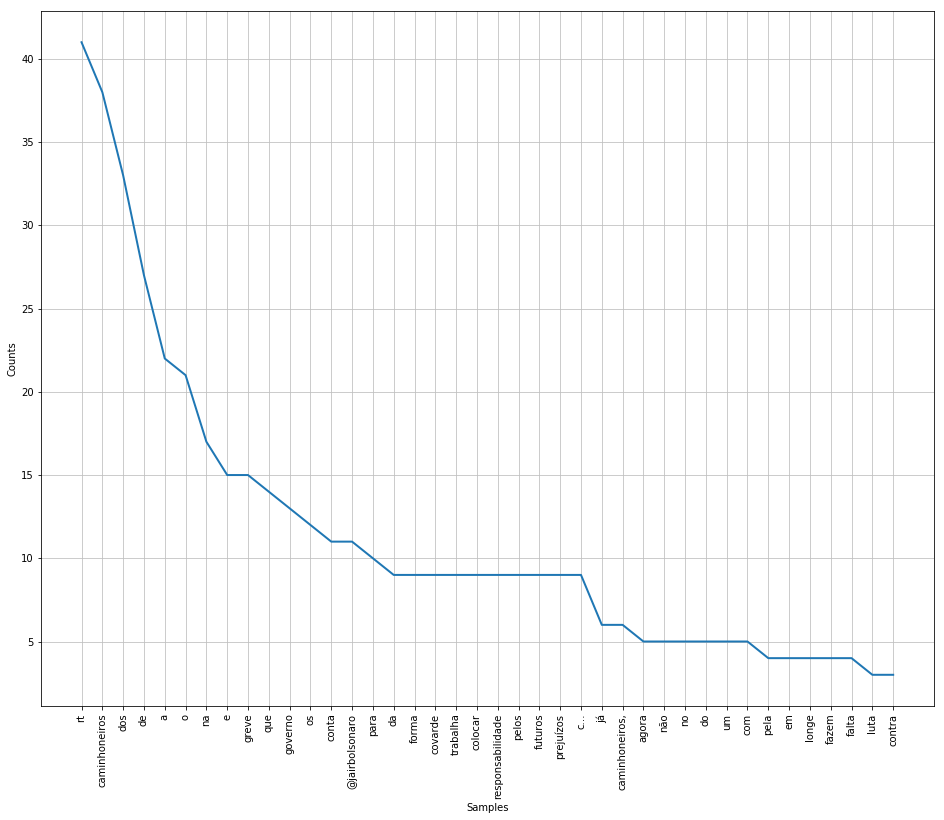

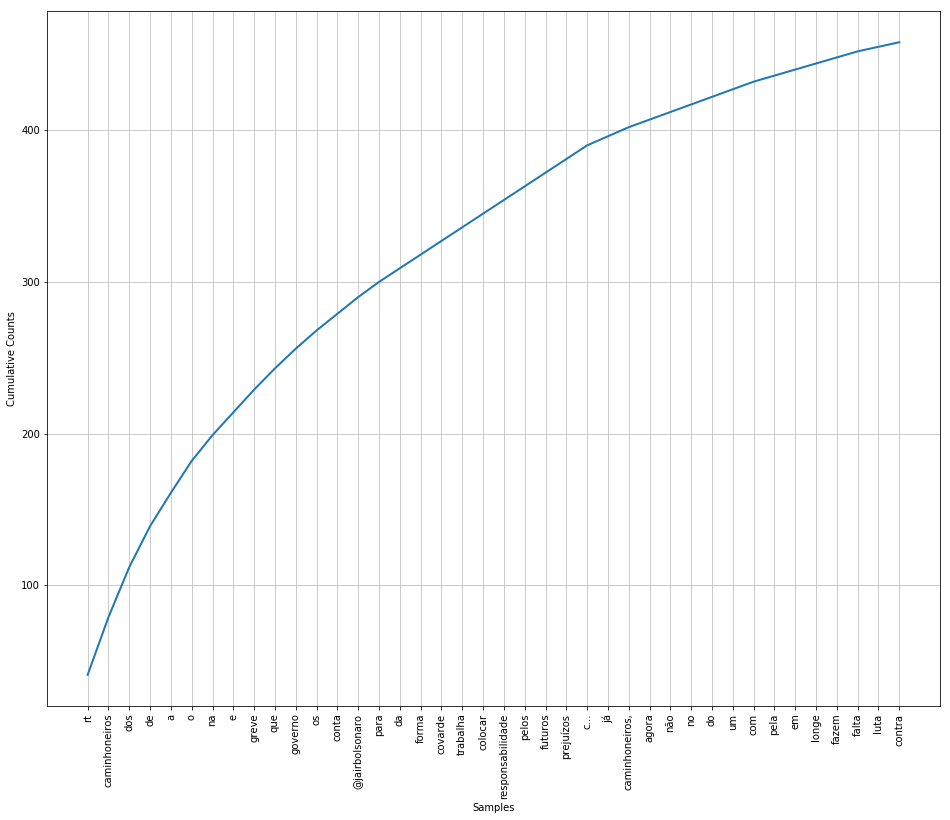

In [66]:
freq_dist = nltk.FreqDist(tweets_words)
freq_dist.plot(40)
freq_dist.plot(40, cumulative = True)

In [67]:
#print('10 most frequent words')
print(freq_dist.most_common())

[('rt', 41), ('caminhoneiros', 38), ('dos', 33), ('de', 27), ('a', 22), ('o', 21), ('na', 17), ('e', 15), ('greve', 15), ('que', 14), ('governo', 13), ('os', 12), ('conta', 11), ('@jairbolsonaro', 11), ('para', 10), ('da', 9), ('forma', 9), ('covarde', 9), ('trabalha', 9), ('colocar', 9), ('responsabilidade', 9), ('pelos', 9), ('futuros', 9), ('prejuízos', 9), ('c…', 9), ('já', 6), ('caminhoneiros,', 6), ('agora', 5), ('não', 5), ('no', 5), ('do', 5), ('um', 5), ('com', 5), ('pela', 4), ('em', 4), ('longe', 4), ('fazem', 4), ('falta', 4), ('luta', 3), ('contra', 3), ('vejo', 3), ('momento', 3), ('as', 3), ('povo', 3), ('@voltaotero', 3), ('atualização', 3), ('caminhoneiros:\n\ncoisas', 3), ('https://t.co/uvkqos8ddg', 3), ('', 3), ('eu', 3), ('parabenizo', 2), ('justa', 2), ('mazelas', 2), ('atingem', 2), ('população', 2), ('causadas', 2), ('corrupção', 2), ('enraizad…', 2), ('https://t.co/vm5j4c9n69', 2), ('fazendo', 2), ('vai', 2), ('eles', 2), ('dia', 2), ('@lucasilveirals', 2), ('me

In [68]:
print('Sorted list of words')
print(sorted(set(tweets_words)))

Sorted list of words
['', '\n\napenas', '\n\npais', '"intervenção', '"não', '"você', "'grupos", '(da', '1973', '4', '64', '@babapsol', '@brasilianfan', '@brunozor', '@ceciconserva', '@diegenes', '@fgamaperes', '@filiperet', '@flaviomorgen', '@fuckingpurpose', '@historianopaint', '@ifobscuro', '@intoxthexdark', '@jairbolsonaro', '@jmarcelo1000', '@jqteixeira', '@lavafabio', '@livrariaemcasa', '@lucasilveirals', '@lucasranngel', '@marinho_surf', '@mark_senkd', '@metriorhynchida', '@milhonara', '@murilocleto', '@rafastrauch', '@sbtjornalismo', '@voltaotero', '@wwwmlna', '@xetdolol', '@youtube', 'a', 'acima', 'acordo', 'acredite', 'adicionei', 'agora', 'agromilícias', 'alexandre', 'allende', 'antigamente', 'ao', 'aos', 'apoiaram', 'apoio', 'armadas', 'as', 'assista', 'atendidas', 'atingem', 'atual.', 'atualização', 'até', 'aulas', 'baderna', 'bolsonaro', 'bom', 'book', 'bosta', 'brasil', 'brasileiro', 'buscam', 'cada', 'caminhoneiros', 'caminhoneiros,', 'caminhoneiros.', 'caminhoneiros.\nd

Same as before, without stopwords. See variable "ignorewords"

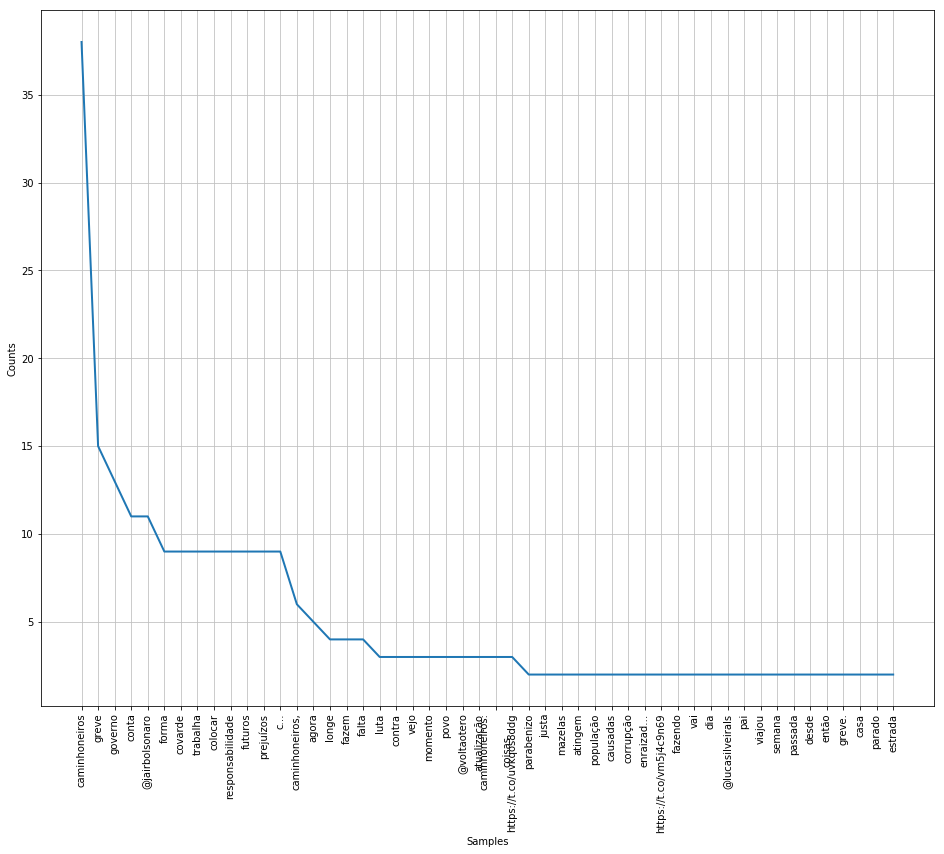

In [69]:
new_tweets_words = [word for word in tweets_words if word not in ignorewords]
    
freq_new = nltk.FreqDist(new_tweets_words)    
freq_new.plot(50)

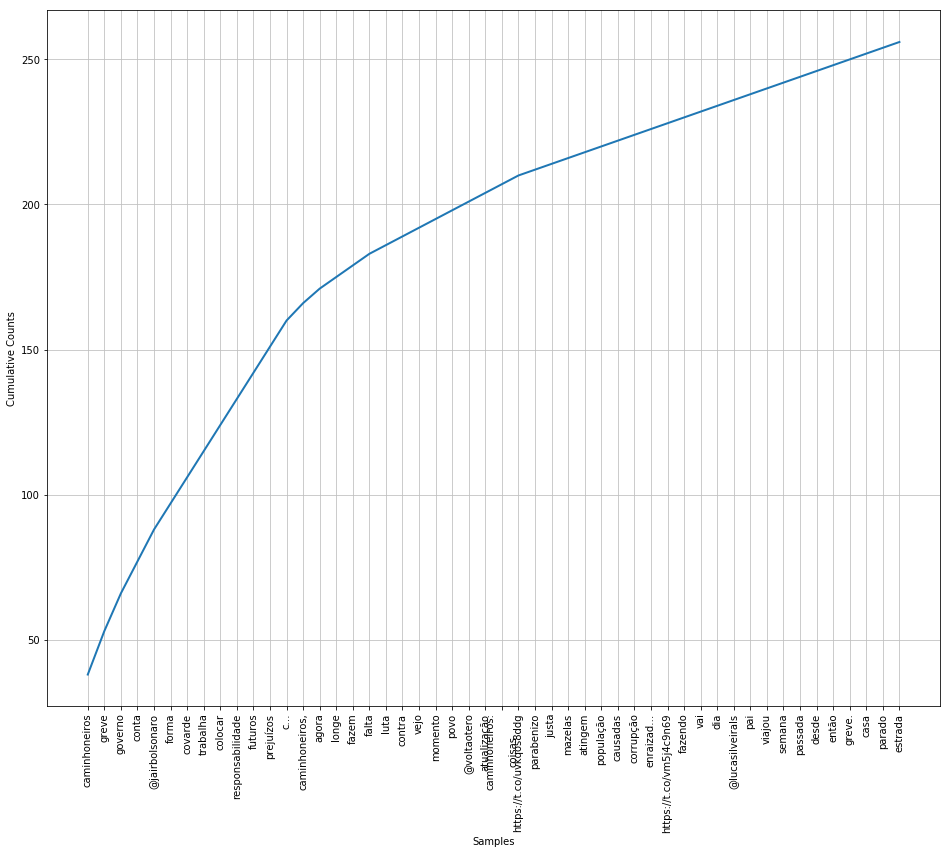

In [70]:
freq_new.plot(50, cumulative = True)

In [71]:
print('10 most frequent words')
print(freq_new.most_common())

10 most frequent words
[('caminhoneiros', 38), ('greve', 15), ('governo', 13), ('conta', 11), ('@jairbolsonaro', 11), ('forma', 9), ('covarde', 9), ('trabalha', 9), ('colocar', 9), ('responsabilidade', 9), ('futuros', 9), ('prejuízos', 9), ('c…', 9), ('caminhoneiros,', 6), ('agora', 5), ('longe', 4), ('fazem', 4), ('falta', 4), ('luta', 3), ('contra', 3), ('vejo', 3), ('momento', 3), ('povo', 3), ('@voltaotero', 3), ('atualização', 3), ('caminhoneiros:\n\ncoisas', 3), ('https://t.co/uvkqos8ddg', 3), ('parabenizo', 2), ('justa', 2), ('mazelas', 2), ('atingem', 2), ('população', 2), ('causadas', 2), ('corrupção', 2), ('enraizad…', 2), ('https://t.co/vm5j4c9n69', 2), ('fazendo', 2), ('vai', 2), ('dia', 2), ('@lucasilveirals', 2), ('pai', 2), ('viajou', 2), ('semana', 2), ('passada', 2), ('desde', 2), ('então', 2), ('greve.', 2), ('casa', 2), ('parado', 2), ('estrada', 2), ('ele…', 2), ('divulgar', 2), ('líder', 2), ('todas', 2), ('@youtube', 2), ('porque', 2), ('ninguém', 2), ('@mark_senk

In [72]:
print('Sorted list of words')
print(sorted(set(new_tweets_words)))

Sorted list of words
['\n\napenas', '\n\npais', '"intervenção', '"não', '"você', "'grupos", '(da', '1973', '4', '64', '@babapsol', '@brasilianfan', '@brunozor', '@ceciconserva', '@diegenes', '@fgamaperes', '@filiperet', '@flaviomorgen', '@fuckingpurpose', '@historianopaint', '@ifobscuro', '@intoxthexdark', '@jairbolsonaro', '@jmarcelo1000', '@jqteixeira', '@lavafabio', '@livrariaemcasa', '@lucasilveirals', '@lucasranngel', '@marinho_surf', '@mark_senkd', '@metriorhynchida', '@milhonara', '@murilocleto', '@rafastrauch', '@sbtjornalismo', '@voltaotero', '@wwwmlna', '@xetdolol', '@youtube', 'acima', 'acordo', 'acredite', 'adicionei', 'agora', 'agromilícias', 'alexandre', 'allende', 'antigamente', 'apoiaram', 'apoio', 'armadas', 'assista', 'atendidas', 'atingem', 'atual.', 'atualização', 'aulas', 'baderna', 'bolsonaro', 'bom', 'book', 'bosta', 'brasil', 'brasileiro', 'buscam', 'cada', 'caminhoneiros', 'caminhoneiros,', 'caminhoneiros.', 'caminhoneiros.\ndepois', 'caminhoneiros...🚚🔴⚫️', 'ca

Counting specific words

In [73]:
print(new_tweets_words.count('greve'))
print(freq_new['gasolina']) #same as before
print(freq_new.freq('greve')) #relative to the others

15
1
0.02727272727272727


Eliminating small words or words with specific sizes

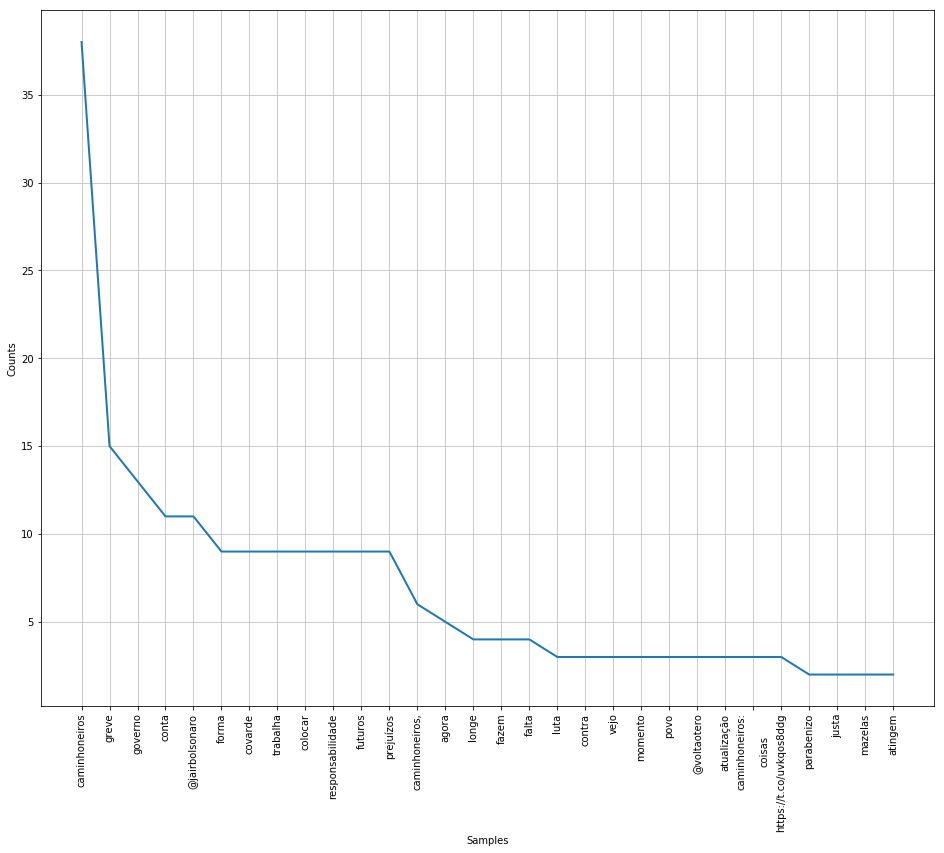

In [74]:
bigger_tweets_words = [word for word in new_tweets_words if len(word) > 2]
#mediumsized_tweets_words = [word for word in new_tweets_words if len(word) > 2 and len(word) < 9]
freq_bigger = nltk.FreqDist(bigger_tweets_words)    
freq_bigger.plot(30)

Citation Analysis

In [75]:
citacoes = [word for word in tweets_words if '@' in word]
#citacoes = [word for word in tweets_words if word.startswith('@')]
freq_citacoes = nltk.FreqDist(citacoes)
freq_citacoes.items()

dict_items([('@diegenes', 1), ('@ceciconserva', 1), ('@brasilianfan', 1), ('@flaviomorgen', 1), ('@wwwmlna', 1), ('@lucasilveirals', 2), ('@rafastrauch', 1), ('@jairbolsonaro', 11), ('@lavafabio', 1), ('@jmarcelo1000', 1), ('@filiperet', 1), ('@voltaotero', 3), ('@youtube', 2), ('@metriorhynchida', 1), ('@jqteixeira', 1), ('@fuckingpurpose', 1), ('@mark_senkd', 2), ('@murilocleto', 1), ('@babapsol', 1), ('@milhonara', 1), ('@xetdolol', 2), ('@fgamaperes', 1), ('@sbtjornalismo', 1), ('@historianopaint', 2), ('@ifobscuro', 1), ('@intoxthexdark', 1), ('@marinho_surf', 1), ('@livrariaemcasa', 1), ('@brunozor', 1), ('@lucasranngel', 1)])

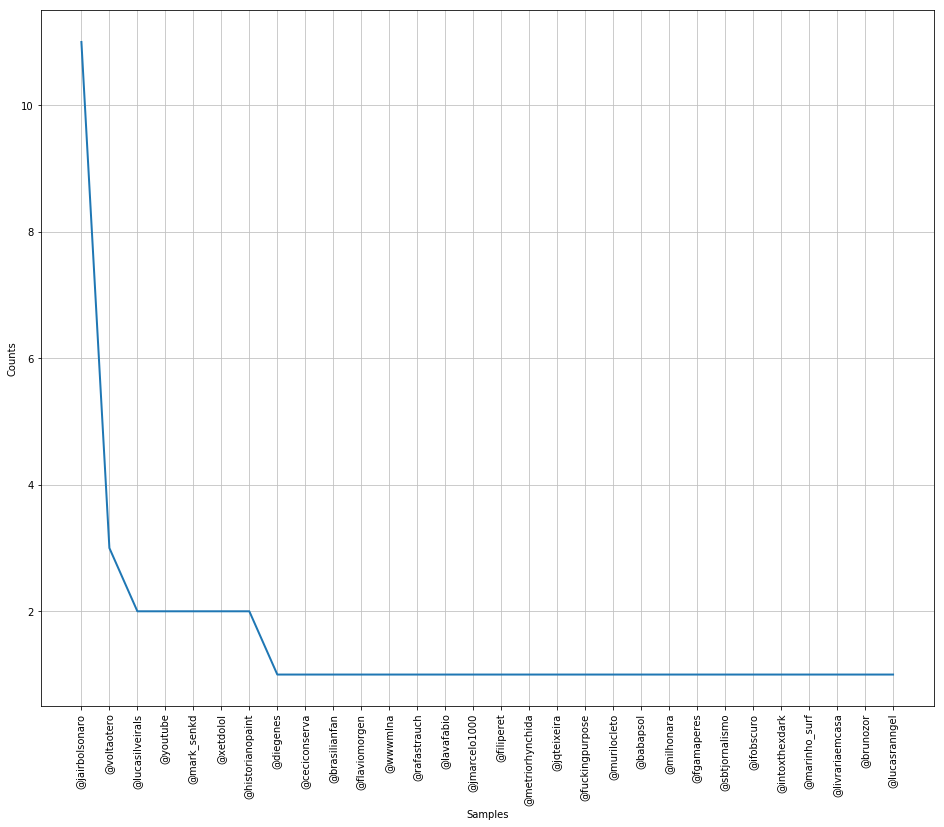

In [76]:
freq_citacoes.plot()

Hashtag Analysis

In [78]:
hashtags = [word for word in tweets_words if '#' in word]
freq_hashtags = nltk.FreqDist(hashtags)
freq_hashtags.items()

dict_items([])

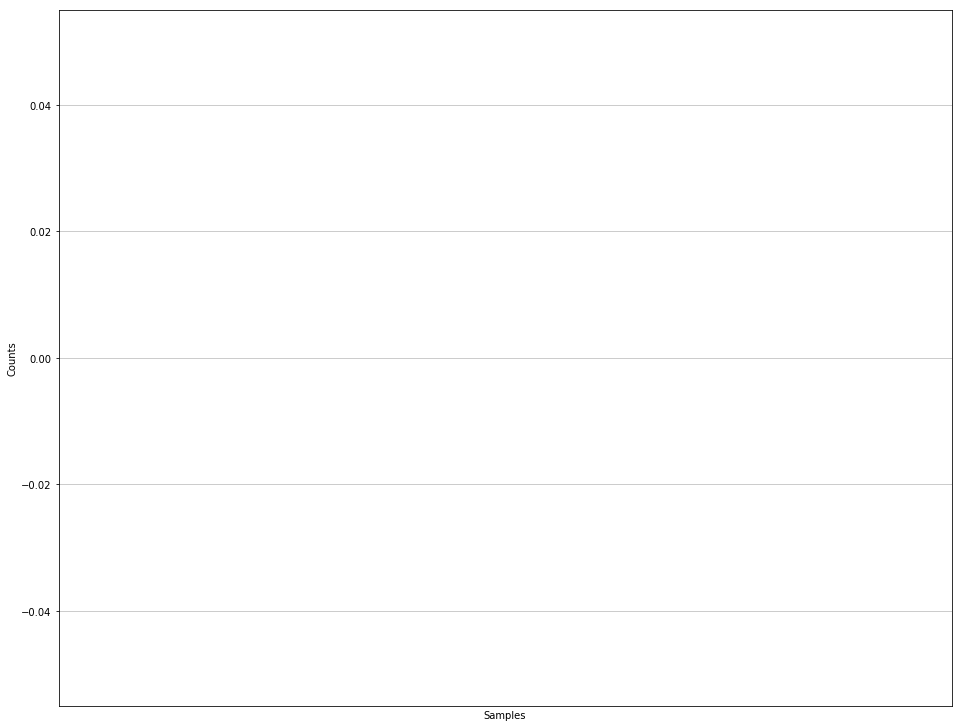

In [79]:
freq_hashtags.plot()

Analysis of Frequent words  
Can be used with any of the previous lists'''

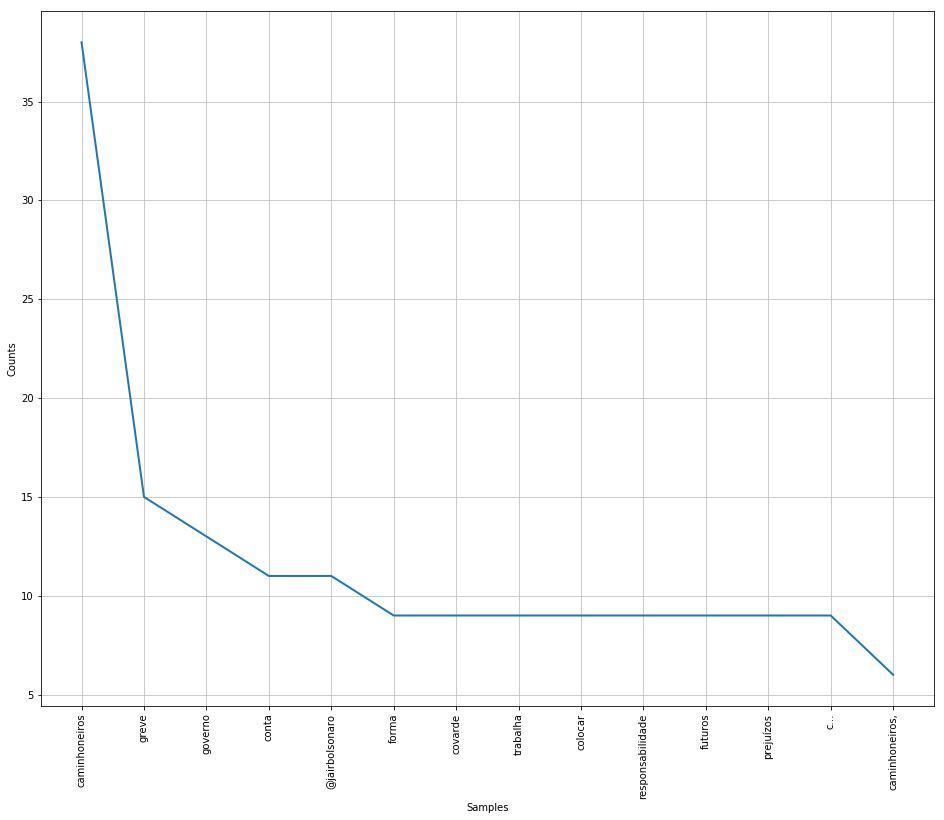

In [80]:
frequent_words = [word.lower() for word in new_tweets_words if tweets_words.count(word) > 5]
freq_dist2 = nltk.FreqDist(frequent_words)
freq_dist2.plot(40)

Words Sizes

In [81]:
freq_size_words = nltk.FreqDist([len(w) for w in new_tweets_words])
freq_size_words.items()

dict_items([(10, 11), (13, 48), (4, 36), (5, 94), (6, 44), (7, 85), (9, 44), (8, 41), (23, 18), (2, 15), (3, 31), (11, 16), (1, 4), (15, 4), (12, 5), (18, 5), (20, 1), (14, 23), (16, 16), (22, 3), (17, 3), (33, 1), (21, 1), (19, 1)])

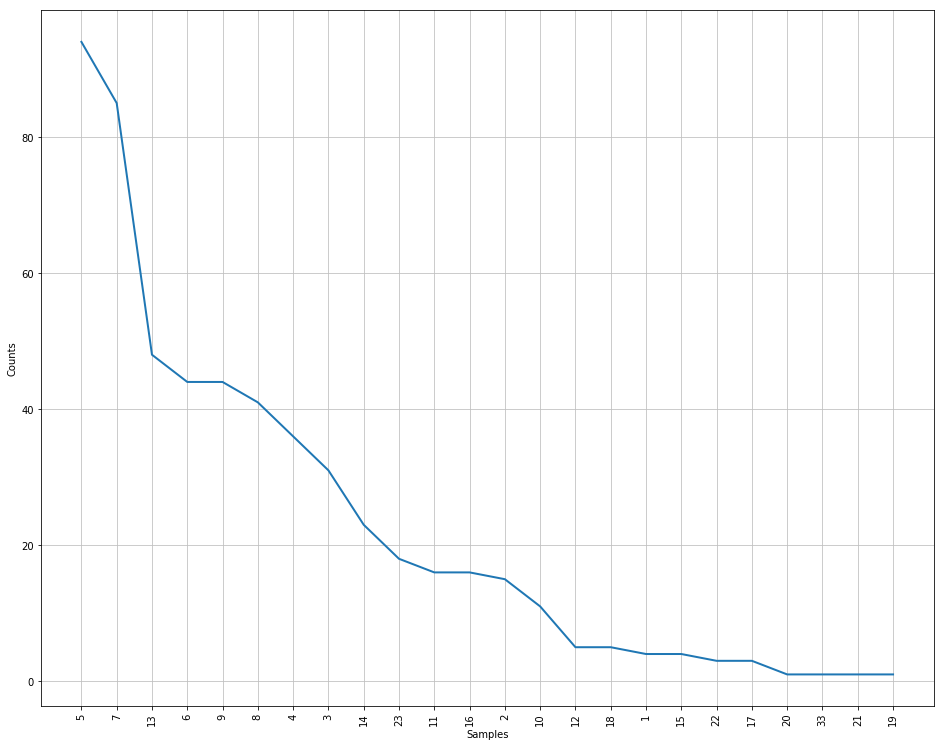

In [82]:
freq_size_words.plot()

Bigrams

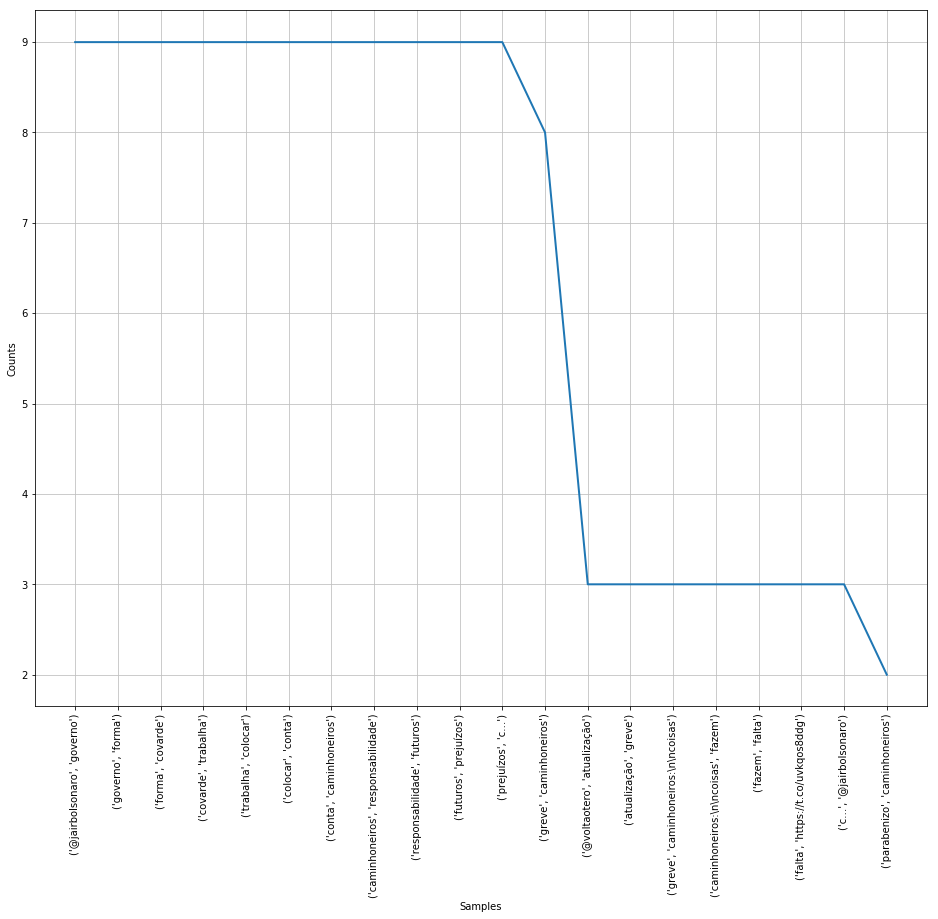

In [83]:
bigramas_tweets = nltk.bigrams(new_tweets_words)
freqbig = nltk.FreqDist(bigramas_tweets)
freqbig.plot(20)

Names (capitalized words)

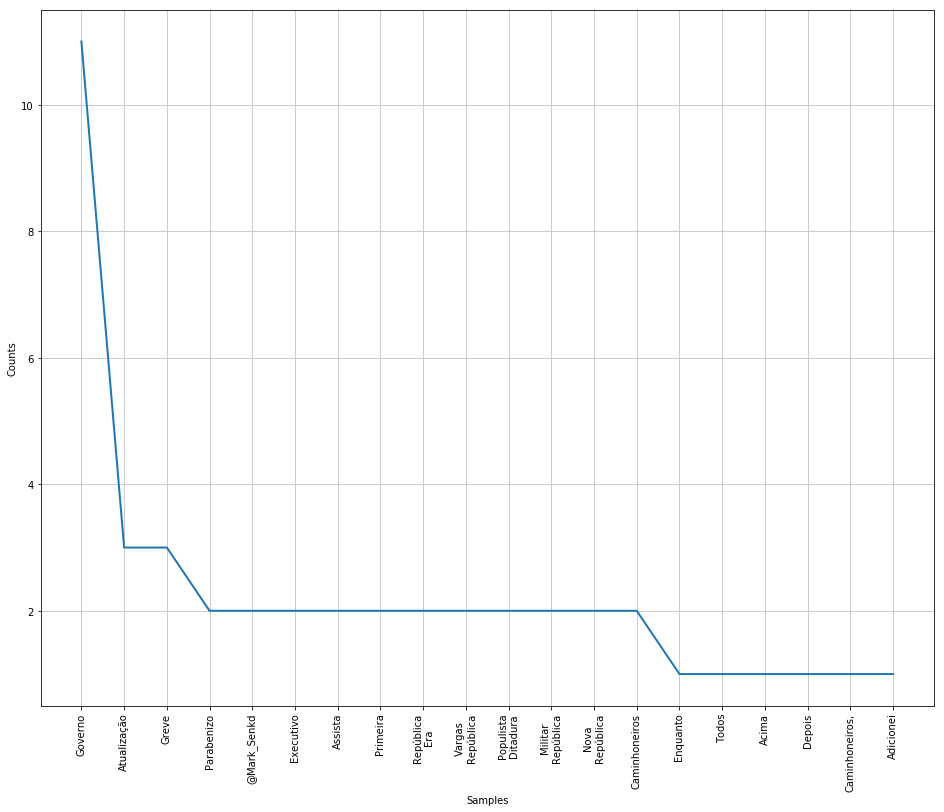

In [84]:
freq_names = nltk.FreqDist(names)
freq_names.plot(20)

#### Sentiment Analysis

In [85]:
badwords =   ['abandoned','abused','accused','addicted','afraid','aggravated',
              'aggressive','alone','angry','anguish','annoyed','anxious','apprehensive',
              'argumentative','artificial','ashamed','assaulted','at a loss','at risk',
              'atrocious','attacked','avoided','awful','awkward','bad','badgered','baffled',
              'banned','barren','beat','beaten down','belittled','berated','betrayed',
              'bitched at','bitter','bizzare','blacklisted','blackmailed','blamed','bleak',
              'blown away','blur','bored','boring','bossed-around','bothered','bothersome',
              'bounded','boxed-in','broken','bruised','brushed-off','bugged','bullied',
              'bummed','bummed out','burdened','burdensome','burned','burned-out',
              'caged in','careless','chaotic','chased','cheated','cheated on','chicken',
              'claustrophobic','clingy','closed','clueless','clumsy','coaxed',
              'codependent','coerced','cold','cold-hearted','combative','commanded',
              'compared','competitive','compulsive','conceited','concerned',
              'condescended to','confined','conflicted','confronted','confused',
              'conned','consumed','contemplative','contempt','contentious','controlled',
              'convicted','cornered','corralled','cowardly','crabby','cramped','cranky',
              'crap','crappy','crazy','creeped out','creepy','critical','criticized',
              'cross','crowded','cruddy','crummy','crushed','cut-down','cut-off','cynical',
              'damaged','damned','dangerous','dark','dazed','dead','deceived','deep',
              'defamed','defeated','defective','defenseless','defensive','defiant',
              'deficient','deflated','degraded','dehumanized','dejected','delicate',
              'deluded','demanding','demeaned','demented','demoralized','demotivated',
              'dependent','depleted','depraved','depressed','deprived','deserted',
              'deserving of pain/punishment','desolate','despair','despairing',
              'desperate','despicable','despised','destroyed','destructive',
              'detached','detest','detestable','detested','devalued','devastated',
              'deviant','devoid','diagnosed','dictated to','different','difficult',
              'directionless','dirty','disabled','disagreeable','disappointed',
              'disappointing','disapproved of','disbelieved','discardable','discarded',
              'disconnected','discontent','discouraged','discriminated','disdain',
              'disdainful','disempowered','disenchanted','disgraced','disgruntled',
              'disgust','disgusted','disheartened','dishonest','dishonorable',
              'disillusioned','dislike','disliked','dismal','dismayed','disorganized',
              'disoriented','disowned','displeased','disposable','disregarded',
              'disrespected','dissatisfied','distant','distracted','distraught',
              'distressed','disturbed','dizzy','dominated','doomed','double-crossed',
              'doubted','doubtful','down','down and out','down in the dumps',
              'downhearted','downtrodden','drained','dramatic','dread','dreadful',
              'dreary','dropped','drunk','dry','dumb','dumped','dumped on','duped',
              'edgy','egocentric','egotistic','egotistical','elusive','emancipated',
              'emasculated','embarrassed','emotional','emotionless','emotionally bankrupt',
              'empty','encumbered','endangered','enraged','enslaved','entangled','evaded',
              'evasive','evicted','excessive','excluded','exhausted','exploited','exposed',
              'fail','failful','fake','false','fear','fearful','fed up','flawed','forced',
              'forgetful','forgettable','forgotten','fragile','freaked out','frightened',
              'frigid','frustrated','furious','gloomy','glum','gothic','grey','grief','grim',
              'gross','grossed-out','grotesque','grouchy','grounded','grumpy','guilt-tripped',
              'guilty','harassed','hard','hard-hearted','harmed','hassled','hate','hateful',
              'hatred','haunted','heartbroken','heartless','heavy-hearted','helpless',
              'hesitant','hideous','hindered','hopeless','horrible','horrified','horror',
              'hostile','hot-tempered','humiliated','hung up','hung over','hurried','hurt',
              'hysterical','idiot','idiotic','ignorant','ignored','ill','ill-tempered',
              'imbalanced','imposed-upon','impotent','imprisoned','impulsive','in the dumps',
              'in the way','inactive','inadequate','incapable','incommunicative','incompetent',
              'incompatible','incomplete','incorrect','indecisive','indifferent',
              'indoctrinated','inebriated','ineffective','inefficient','inferior',
              'infuriated','inhibited','inhumane','injured','injusticed','insane',
              'insecure','insignificant','insincere','insufficient','insulted',
              'intense','interrogated','interrupted','intimidated','intoxicated',
              'invalidated','invisible','irrational','irritable','irritated',
              'isolated','jaded','jealous','jerked around','joyless','judged',
              'kept apart','kept away','kept in','kept out','kept quiet','labeled',
              'laughable','laughed at','lazy','leaned on','lectured to','left out',
              'let down','lied about','lied to','limited','little','lonely','lonesome',
              'longing','lost','lousy','loveless','low','mad','made fun of','man handled',
              'manipulated','masochistic','messed with','messed up','messy','miffed',
              'miserable','misled','mistaken','mistreated','mistrusted','misunderstood',
              'mixed-up','mocked','molested','moody','nagged','needy','negative',
              'nervous','neurotic','nonconforming','numb','nuts','nutty','objectified',
              'obligated','obsessed','obsessive','obstructed','odd','offended',
              'on display','opposed','oppressed','out of place','out of touch',
              'over-controlled','over-protected','overwhelmed','pain','panic','paranoid',
              'passive','pathetic','pessimistic','petrified','phony','picked on','pissed',
              'pissed off','plain','played with','pooped','poor','powerless','pre-judged',
              'preached to','preoccupied','predjudiced','pressured','prosecuted',
              'provoked','psychopathic','psychotic','pulled apart','pulled back',
              'punished','pushed','pushed away','put down','puzzled','quarrelsome',
              'queer','questioned','quiet','rage','raped','rattled','regret','rejected',
              'resented','resentful','responsible','retarded','revengeful','ridiculed',
              'ridiculous','robbed','rotten','sad','sadistic','sarcastic','scared',
              'scarred','screwed','screwed over','screwed up','self-centered','self-conscious',
              'self-destructive','self-hatred','selfish','sensitive','shouted at','shy',
              'singled-out','slow','small','smothered','snapped at','spiteful','stereotyped',
              'strange','stressed','stretched','stuck','stupid','submissive','suffering',
              'suffocated','suicidal','superficial','suppressed','suspicious','worse','worst'
              ,'bankrupcy','jobs','shit','#sob']

In [86]:
goodwords =  ['Abundant','Accomplished','Achieving','Active','Admirable','Adorable',
              'Adventurous','Admired','Affluent','Agreeable','Alert','Aligned','Alive',
              'Amazing','Appealing','Appreciate','Artistic','Astounding','Astute',
              'Attentive','Attractive','Auspicious','Authentic','Awake','Aware','Awesome',
              'Beaming','Beautiful','Better','Best','Blessed','Bliss','Bold','Bright','Brilliant',
              'Brisk','Buoyant','Calm','Capable','Centered','Certain','Charming',
              'Cheerful','Clear','Clever','Competent','Complete','Confident','Connected',
              'Conscious','Considerate','Convenient','Courageous','Creative','Daring',
              'Dazzling','Delicious','Delightful','Desirable','Determined','Diligent',
              'Discerning','Discover','Dynamic','Eager','Easy','Efficient','Effortless',
              'Elegant','Eloquent','Energetic','Endless','Enhancing','Engaging','Enormous'
              ,'Enterprising','Enthusiastic','Enticing','Excellent','Exceptional','Exciting'
              ,'Experienced','Exquisite','Fabulous','Fair','Far-Sighted','Fascinating',
              'Fine','Flattering','Flourishing','Fortunate','Free','Friendly','Fulfilled',
              'Fun','Generous','Genuine','Gifted','Glorious','Glowing','Good','Good-Looking',
              'Gorgeous','Graceful','Gracious','Grand','Great','Handsome','Happy','Hardy',
              'Harmonious','Healed','Healthy','Helpful','Honest','Humorous','Ideal',
              'Imaginative','Impressive','Industrious','Ingenious','Innovative','Inspired',
              'Intelligent','Interested','Interesting','Intuitive','Inventive','Invincible',
              'Inviting','Irresistible','Joyous','Judicious','Keen','Kind','Knowing','Leader',
              'Limitless','Lively','Loving','Lucky','Luminous','Magical','Magnificent',
              'Marvellous','Masterful','Mighty','Miraculous','Motivated','Natural','Neat',
              'Nice','Nurturing','Noble','Optimistic','Outstanding','Passionate','Peaceful',
              'Perfect','Persevering','Persistent','Playful','Pleasing','Plentiful','Positive',
              'Powerful','Precious','Prepared','Productive','Profound','Prompt','Prosperous',
              'Proud','Qualified','Quick','Radiant','Reasonable','Refined','Refreshing',
              'Relaxing','Reliable','Remarkable','Resolute','Resourceful','Respected',
              'Rewarding','Robust','Safe','Satisfied','Secure','Seductive','Self-Reliant',
              'Sensational','Sensible','Sensitive','Serene','Sharing','Skilful','Smart',
              'Smashing','Smooth','Sparkling','Spiritual','Splendid','Strong','Stunning',
              'Successful','Superb','Swift','Talented','Tenacious','Terrific','Thankful',
              'Thrilling','Thriving','Timely','Trusting','Truthful','Ultimate','Unique',
              'Valiant','Valuable','Versatile','Vibrant','Victorious','Vigorous','Vivacious',
              'Vivid','Warm','Wealthy','Well','Whole','Wise','Wonderful','Worthy','Young',
              'Youthful','Zeal','Zest']

In [87]:
def percentage(count, total):
    return 100 * count / float(total)

In [88]:
def sentiment_analysis(texto, goodwords, badwords):
    '''
    Not a sophisticated one, but the main idea is present.
    Please read: http://alias-i.com/lingpipe/demos/tutorial/sentiment/read-me.html
    '''
    goodness = 0
    badness = 0    
    for word in goodwords:
        goodness += percentage(texto.count(word.lower()), len(texto))
    for word in badwords:
        badness += percentage(texto.count(word.lower()), len(texto))
    if badness:
        ratio = goodness/float(badness)
    print(u'Grau de negatividade: {}'.format(badness))
    print(u'Grau de positividade: {}'.format(goodness))
    if badness:
        print(u'Razão: {}'.format(ratio))
    return goodness, badness

In [89]:
sentiment_analysis(tweets_words, goodwords, badwords);

Grau de negatividade: 0.0
Grau de positividade: 0.0


#### Geographic Analysis

https://pypi.python.org/pypi/basemap/1.0.7  
http://matplotlib.org/basemap/  
http://matplotlib.org/basemap/users/installing.html  
https://github.com/SciTools/Cartopy  
https://scitools.org.uk/cartopy/docs/v0.15/installing.html  
http://nbviewer.ipython.org/github/ehmatthes/intro_programming/blob/master/notebooks/visualization_earthquakes.ipynb  

In [58]:
msgpublicas = api.GetStreamSample()
geo_points = 0
lats, lons = [], []
users = []
while geo_points < 20:
    tweet = next(msgpublicas)
    if 'coordinates' in tweet.keys() and tweet['coordinates'] != None:
        coords = tweet['coordinates']['coordinates']
        user = tweet['user']['id']
        print(u'Usuário {} nas coordenadas {}'.format(user, [coords[1],coords[0]]))
        lons.append(float(coords[0]))
        lats.append(float(coords[1]))
        users.append(user)
        geo_points +=1

Usuário 804816424321634304 nas coordenadas [46.813, 8.4445]
Usuário 1180025371 nas coordenadas [38.8991, -77.029]
Usuário 160226388 nas coordenadas [51.6708, 39.2142]
Usuário 2669983818 nas coordenadas [40.4313474, -80.0505398]
Usuário 728702352224477184 nas coordenadas [32.5023445, -116.9449512]
Usuário 169144873 nas coordenadas [25.1393077, 121.4893202]
Usuário 29539985 nas coordenadas [34.0522, -118.243]
Usuário 88113750 nas coordenadas [32.9139398, -84.3316267]
Usuário 2669983818 nas coordenadas [-6.693558, 39.258081]
Usuário 21835695 nas coordenadas [33.5080943, -112.0863874]
Usuário 4291619232 nas coordenadas [33.76232637, -118.19648467]
Usuário 34571429 nas coordenadas [49.25147547, 8.86461674]
Usuário 72033272 nas coordenadas [44.7706278, -85.4769994]
Usuário 1137092480 nas coordenadas [5.55, -0.2]
Usuário 1372665186 nas coordenadas [15.5931, 120.7391]
Usuário 475537736 nas coordenadas [39.0, -76.7]
Usuário 1372665186 nas coordenadas [15.5931, 120.7391]
Usuário 237974132 nas co

/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


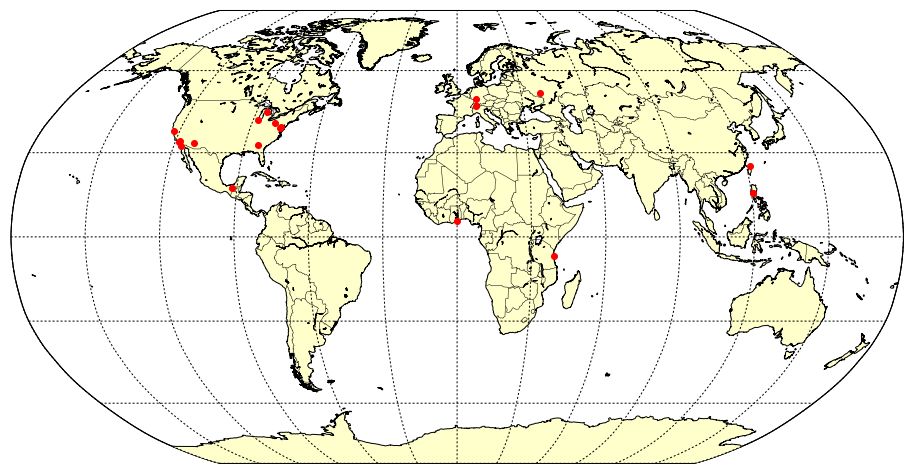

In [59]:
map = Basemap(projection='robin', resolution = 'l', area_thresh = 1000.0, lat_0=0, lon_0=0)

map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color = '#FFFFCC') #http://www.w3schools.com/tags/ref_colorpicker.asp
map.drawmapboundary()
map.drawmeridians(np.arange(0, 360, 30))
map.drawparallels(np.arange(-90, 90, 30))

x,y = map(lons, lats)
map.plot(x, y, 'ro', markersize=6)
plt.show()

/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


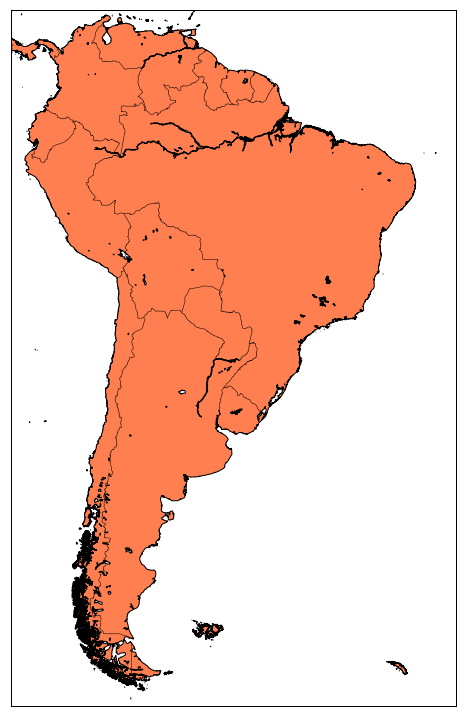

In [60]:
map = Basemap(projection='merc', lat_0 = -22, lon_0 = -56.5,resolution = 'h', area_thresh = 0.1, 
              llcrnrlon=-83.0, llcrnrlat=-57.0, urcrnrlon=-30.0, urcrnrlat=13.0)
 
map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color = 'coral')
map.drawmapboundary()

x,y = map(lons, lats)
map.plot(x, y, 'bo', markersize=10)

plt.show()

Zoom em uma coordenada:

In [61]:
def gmap(lat,lon,zoom=10):
    # Google Maps URL template for an iframe
    google_maps_url = "http://maps.google.com/maps?q={0}+{1}&ie=UTF8&t=h&z={2}&{0},{1}&output=embed".format(lat,lon,zoom)
    display(IFrame(google_maps_url, '800px', '600px'))

In [62]:
gmap(lats[0],lons[0],4)

#### Graphs

http://networkx.lanl.gov/  

In [63]:
def get_rt_origins(tweet):
    ''' Regex adapted from 
    http://stackoverflow.com/questions/655903/python-regular-expression-for-retweets'''
    rt_patterns = re.compile(r"(RT|via)((?:\b\W*@\w+)+)", re.IGNORECASE)
    rt_origins = []
    try:
        rt_origins += [mention.strip() for mention in rt_patterns.findall(tweet)[0][1].split()]
    except IndexError as e:
        pass
    return [rto.strip("@") for rto in rt_origins]

In [64]:
def create_graph_retweets(tweets):
    g = nx.DiGraph()
    for tweet in tweets:
        rt_origins = get_rt_origins(tweet.text)
        if not rt_origins:
            continue
        for rt_origin in rt_origins:
            g.add_edge(rt_origin, tweet.user.screen_name, {'tweet_id': tweet.id})
    return g

In [65]:
g_rt = create_graph_retweets(tweets)
print("Number of nodes is: {}\n".format(g_rt.number_of_nodes()))
print("Number of edges is: {}\n".format(g_rt.number_of_edges()))

Number of nodes is: 57

Number of edges is: 31



In [66]:
import operator
sorted_dic = sorted(g_rt.degree().items(), key=operator.itemgetter(1), reverse=True)
sorted_dic

[('DenisMacShane', 3),
 ('mnewyork17', 2),
 ('HugoGuillemet', 2),
 ('Bonn1eGreer', 2),
 ('LaBrunette_du59', 1),
 ('pictoline', 1),
 ('VictorGonz54', 1),
 ('IMacu21', 1),
 ('leJDD', 1),
 ('Pinboard', 1),
 ('lintlvieno', 1),
 ('LaMortLaVraie', 1),
 ('JeanLucRomero', 1),
 ('StromoUK', 1),
 ('KingYoann', 1),
 ('davcarretta', 1),
 ('AgCoffre', 1),
 ('marioraulnegri', 1),
 ('Ruminations17', 1),
 ('soniaber1guer', 1),
 ('Romain14771230', 1),
 ('_ssweet93', 1),
 ('DesportOfficiel', 1),
 ('robotmlg', 1),
 ('chiaberger', 1),
 ('Praline_addict', 1),
 ('la1ere', 1),
 ('AndyRotham', 1),
 ('carli_p', 1),
 ('NPR', 1),
 ('clakklaa', 1),
 ('luzsmellado', 1),
 ('20Minutes', 1),
 ('mcappell', 1),
 ('Paulinepooo', 1),
 ('Matt_Moore88', 1),
 ('blafergon14', 1),
 ('chrisdeerin', 1),
 ('jimwaterson', 1),
 ('livindavidal', 1),
 ('CNNEE', 1),
 ('MsMainstay', 1),
 ('Logan_Veniel', 1),
 ('esheikh_:', 1),
 ('France24_en', 1),
 ('MichuLele1', 1),
 ('ivancouronne', 1),
 ('lemondefr', 1),
 ('LeHuffPost', 1),
 ('jcal

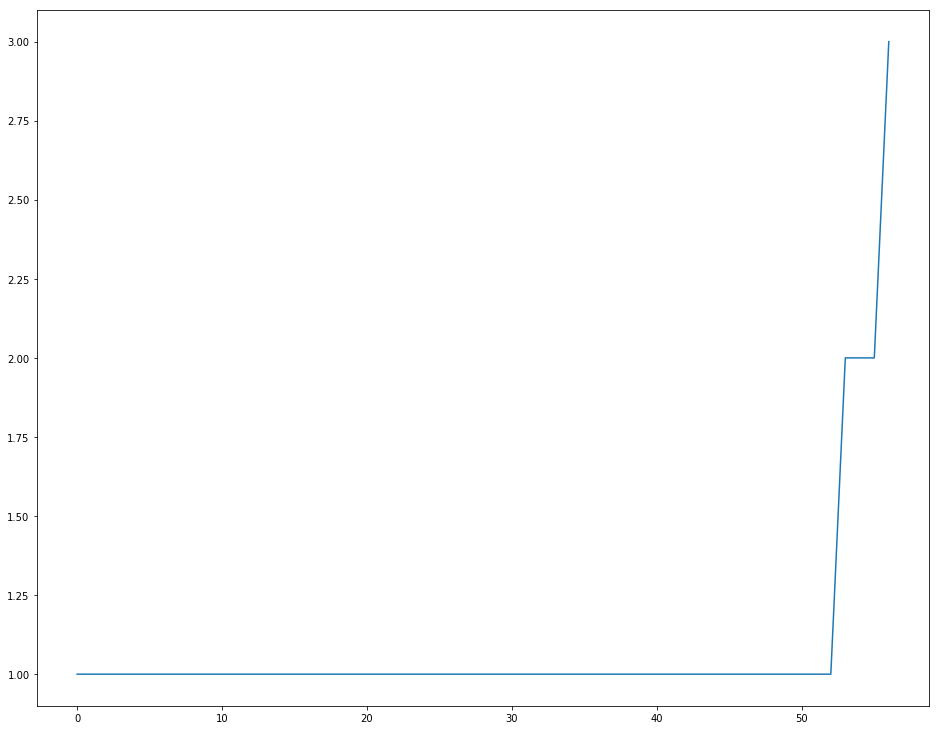

In [67]:
dic = nx.degree(g_rt)
plt.plot(sorted(dic.values()))

In [68]:
def save_dotfile(g):
    try:
        nx.drawing.write_dot(g, pathdotfile)
        print >> sys.stderr, 'Graph exported for file: {}'.format(pathdotfile)
    except (ImportError, UnicodeEncodeError, AttributeError): 
        # Este bloco serve para usuarios de windows, que certamente terao problemas
        # com o metodo nx.drawing.write_dot. Tambem serve para os casos em que temos
        # problemas com o unicode
        dot = [u'"{}" -> "{}" [tweet_id={}]'.format(n1, n2, g[n1][n2]['tweet_id']) for (n1, n2) in g.edges()]
        f = codecs.open(pathdotfile, 'w', encoding='utf-8')
        f.write('''strict digraph {{}}'''.format(';\n'.join(dot), ))
        f.close()
        print(sys.stderr, 'Graph exported for file: {}'.format(pathdotfile))
        return f.name

In [69]:
save_dotfile(g_rt)

<ipykernel.iostream.OutStream object at 0x7fa96c5cda20> Graph exported for file: ../outputs/graph_retweet.dot


'../outputs/graph_retweet.dot'

Saving a dotfile

Obs: To generate a png graph from the dotfile, type in the Unix Prompt: 
'circo -Tpng -Gcharset=latin1 -Ograph_retweet graph_retweet.dot'

In [70]:
#Chamando um programa externo ao Ipython com o operador !
!dot -Tpng ../outputs/graph_retweet.dot -o ../outputs/graph_retweet.png
Image(pathpngfile)

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/local/lib/python3.5/dist-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


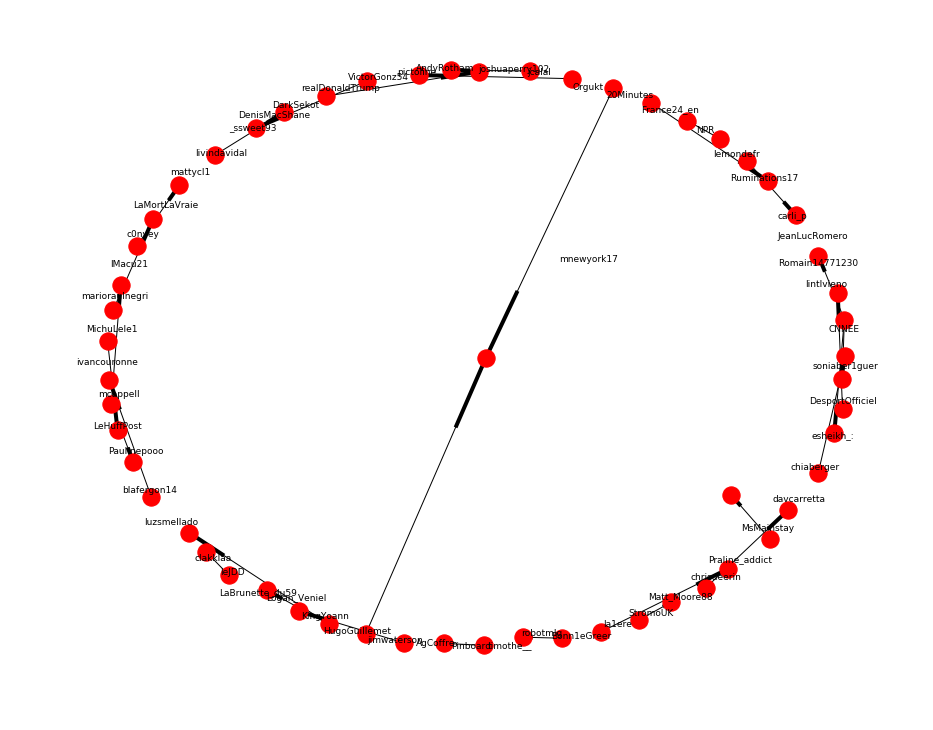

In [71]:
nx.draw_networkx_labels(g_rt,pos=nx.spring_layout(g_rt),font_size=9)
nx.draw(g_rt)
#nx.draw_random(g_rt)
#nx.draw_circular(g_rt)
#nx.draw_spectral(g_rt)

Saving a HTML file that uses javascript for visualizing the graph (needs a template)

In [72]:
def save_protovis_file(g):
    '''A visualization alternative is "protovis" javascript
    It uses the files "template_protoviz.html and "protovis-r3.2.js"
    '''
    nodes = g.nodes()
    indexed_nodes = {}
    idx = 0
    for n in nodes:
        indexed_nodes.update([(n, idx,)])
        idx += 1
    links = []
    for n1, n2 in g.edges():
        links.append({'source': indexed_nodes[n2],'target': indexed_nodes[n1]})
    json_data = json.dumps({"nodes" : [{"nodeName" : n} for n in nodes], "links" : links}, indent=4)
    html = open(pathtemplate).read().format(json_data,)
    f = open(pathprotofile, 'w')
    f.write(html)
    f.close()
    print(sys.stderr, 'Graph exported for file: {}'.format(pathprotofile))
    return f.name, html

In [73]:
s = save_protovis_file(g_rt)

<ipykernel.iostream.OutStream object at 0x7fa96c5cda20> Graph exported for file: ../outputs/graph_retweet.html


In [74]:
#!chromium ../outputs/graph_retweet.html
# http://docs.python.org/library/webbrowser.html 

webbrowser.open(pathprotofile)

True